In [1]:
import re
from os import path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV,
)
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
290119,1559953338287915013,muito bom 😹😹😹,0.427119,1
493349,1160675662321111048,eliana aposta em look all black e barriguinha ...,0.677937,1
667297,1160908601160032256,mo gatinha 💖,0.713381,1
247301,1559916180273504257,se o flamengo vencer hoje o furacão e domingo ...,0.779012,1
357669,1559986200974442496,eu i a cria enchendo a pança 😅,0.179654,0
181942,1559890688325652480,homem serve p isso 😝😝,0.850806,1
161135,1559881610111107072,queria dormir o dia todo hoje 🥹 me sentindo tr...,-0.118421,-1
189184,1559893708472025089,tô muito feliz 🥰😍🙌,1.238362,1
156702,1559879517635747840,mas há males na vida que vem para o bem...🎼🎶💃,1.275093,1
372846,1559992156470796292,só existe um jeito de tudo melhorar😋,0.633515,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

83       hão
118    muito
1          à
164      sua
27      elas
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: ahahaha olha, cuida do meu ruski, e de ti também ❤

Tweet Limpo   : ahahaha olha cuida ruski ti

Tweet Stemed  : ahahah olh cuid rusk ti


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
86270,1559839520983490561,tudo que eu queria era não ir pra mrg hoje 😪😪,-0.161826,-1,tud quer ir pra mrg hoj
480825,1160639259629502470,cosita linda 😍,0.677937,1,cosit lind
596896,1160766914974691329,atrofiar com o dala é do crlh 😂,0.220968,0,atrofi dal crlh
177619,1559888887576776705,😫 só pq eu tô pobre e tava tudo no precinho,-0.145610,-1,pq tô pobr tav tud prec
6686,1559740705727303680,vc está casada com uma maior de idade 😎,0.493369,1,vc cas mai idad


# Engenharia de Atributos: Count Vectorizer

Este modelo utiliza uma matriz esparsa com a frequencia de cada palavra.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

### Count Vectorizer

In [11]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectorizer.fit(X_train["cleaned"])

CountVectorizer(ngram_range=(1, 2))

#### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [12]:
X_features_train = vectorizer.transform(X_train["cleaned"])
y_features_train = X_train["label"]

#### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [13]:
X_features_test = vectorizer.transform(X_test["cleaned"])
y_features_test = X_test["label"]

## Seleção de Atributos

Referência:

- [https://en.wikipedia.org/wiki/Feature_selection](https://en.wikipedia.org/wiki/Feature_selection)
- [https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [14]:
selector = SelectPercentile(f_classif, percentile=50)

selector.fit(X_features_train, y_features_train)

SelectPercentile(percentile=50)

In [15]:
X_features_train_selected = selector.transform(X_features_train)
X_features_test_selected = selector.transform(X_features_test)

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [16]:
# Inicializar o Scaler
scaler = StandardScaler(with_mean=False)

# Treinar o Scaler
scaler.fit(X_features_train_selected)

StandardScaler(with_mean=False)

In [17]:
# Transformar o conjunto de treinamento
X_features_train_scaled = scaler.transform(X_features_train_selected)

In [18]:
X_features_test_scaled = scaler.transform(X_features_test_selected)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [19]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [20]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [21]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [22]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Naive Bayes

Referências:
- [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

In [23]:
nb = MultinomialNB()

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [24]:
params = {
    "alpha": np.sort(np.append(np.linspace(0.5, 1.5, 20), 1)),
}

clf = RandomizedSearchCV(
    nb, params, n_iter=10, scoring="f1_weighted", n_jobs=-1, random_state=42
)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 65.97%


In [25]:
clf.best_params_

{'alpha': 1.394736842105263}

In [26]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [27]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 43.03%
Score Modelo   : 65.97%
Diferença      : 22.95%


### Performance no Conjunto de Treino

In [28]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 87.18%


### Curva de Aprendizado

In [29]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

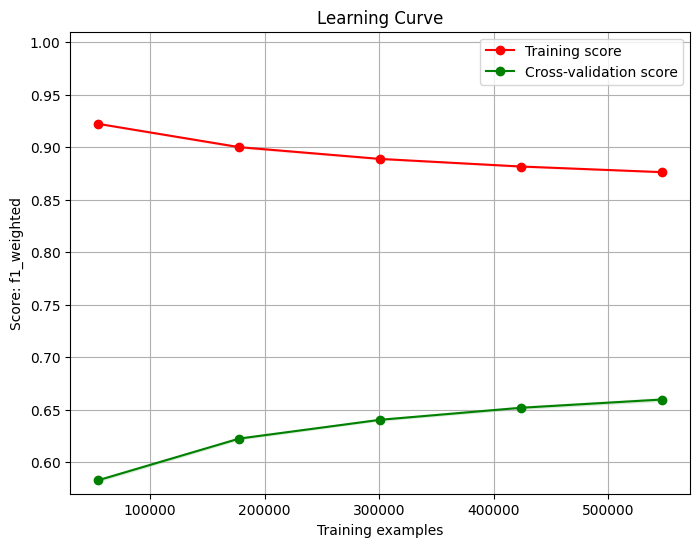

In [30]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [31]:
y_pred = classifier.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 59.26%


### Preditos Positivos

In [32]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [33]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['pois é poxa, é uma pena mesmo 😐',
       'então espera sair depois você estuda 😭😭😭',
       'será que o tt derrubou o alcance do meu perfil tbm? sacanagem 😒',
       'já não tenho idade p jogar uma peladinha intensa de h 😣',
       'ate rem 😭😭😭 congrats po 😭', 'louca por um bolo de chocolate 😕',
       'a gente surtando e eles 😑😑', 'nem dessa eu posso participar 😡',
       'inveja total 😔', 'puse sex,no ptm😞'], dtype=object)

#### Falso Positivo -> Neutro

In [34]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['quero larga uns ha ha ha na canela 👀',
       'postei uma foto tão 🔥 no meus melhores amigos do insta...',
       'segundo o ibge, água preta tem mil habitantes. e a cada pessoas, é candidato a conselheiro tutelar 😂',
       '🙋eu concordo plenamente e se quiser assino em baixo 😅',
       'sem tempo pra esses pseudo desconstruídos 😂', '💯 amor.',
       'nada passa batido 🤗👀', 'apreciava todo o dia 😢',
       'o frota era o ícone da família tradicional e cristã do psl... sem ele, como ficará essa imagem? 😱',
       'sei nem ir lá, ela tá de brincadeirinha 😂'], dtype=object)

#### Verdadeiro Positivo

In [35]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['ficou mesmo ✌🏻', 'se depender d mim as lágrimas vão t afogar 🎶',
       'viva o amor ! 💖', 'eu tbm ❤', 'feliz dia dos pais ❤', 'nada ❤️',
       'se o açaí for do pará kkkķkkk açaí. sou exigente, não aceito menos em nada. rann ❤',
       'sdv garantido. 🇧🇷 bolsonaro 🇧🇷 ▶️ " " 👉reeleito em 🇧🇷 governa até ▶️ .',
       'ajudo! chama no dm 😎', 'feliz aniversário 🎈'], dtype=object)

### Preditos Negativos

In [36]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [37]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['passando o dia dos pais vendo documentário de esquerda com meu pai 👍',
       'todo mundo ja sabe quem vai ficar na final, nem me choco. eduardo sai na proxima e fica lorena e rodrigo. amo 💕',
       'vou volta a dormir e mas tarde leva meu dengo pra corta o cabelo 💕',
       'sou mto sensitiva mesmo cara, eu tenho q acreditar mas nisso. vi um stories de um amigo meu e ele estava muito abatido e eu senti que ele estava com câncer, não perguntei p não ser indelicada, hoje ele postou que começou o tratamento ! fiquei em choque. q deus o abençoe 🙏',
       'a beleza de todas as pessoas do mundo, esses dois estão a carregar sozinhos😭😍',
       'aquele negócio de q “ tudo acaba em pizza!”, tô aqui levando ao pé da letra 😋',
       'bom dia, pq eu estou acordando agora 😌', 'mó gatinhooo 😍',
       ': no trabalho zerado, feliz e tranquilo, eu venci. eu sou a universal 😁',
       'sua luz deve brilhar de dentro pra fora. ✨'], dtype=object)

#### Falso Negativo -> Neutro

In [38]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['belém: terça-feira, : , graus. sensação termina de graus. 😰',
       'cada dia piora mais tô só observando 👀', 'a raiva é essa 😅',
       'vc ficou tão fofo falando de si mesmo na ª pessoa. me senti a jane, 😂 brincadeira, terito. eu jamais…',
       'tambem nao fui😰', 'to muito idosa, já to caindo de sono 😂',
       'jimin fazendo live só pq tenho q ir ao médico 😥',
       'esse bagre, faz porra nem uma 😂', 'também quero 😂',
       'mas aí se tu quer informação tu tem que ir atrás de um jornalista, pô. tenho pretensão nenhuma em te ajudar 😅'],
      dtype=object)

#### Verdadeiro Negativo

In [39]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['ver essa série 😴', 'meu rosto tá terrível 😭', 'dormir né 😴',
       'dia só .. bom vai ficar quando essa dor do inferno passar 😔',
       'almoçar na escola por causa de uma aula so amg 💀💀💀',
       'sim!! isso fez meu coração ficar ainda mais apertado. 😭😭\U0001f979',
       'eu queria tanto sair mais tarde 😞 😴',
       'preciso comprar roupa, as minhas não estão cabendo 😭',
       'deixei os fones na sala 😤', 'mds eu vou ficar sozinha dnv😭😭'],
      dtype=object)

### Preditos Neutros

In [40]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [41]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['estou solteiro tbm, olha que coincidência 😏 rs',
       'ahhh pra vcs também!!! 💜',
       'tu e liardison é tudo fogo de palha vai e volta e pra ser msm — 😉',
       'hey , avisa o dev que o teste funcionou 👍',
       '*produtividade no* trabalho: 🥰🤩😘 universidade: 💩😠🤪',
       'pique show do gustavo lima pistola pra cima pra elas entrar no clima 🎶',
       'sério?? que bonitinha, feliz aniversário! 💛',
       'espartilhos de luxo 💋 você vai se apaixonar 💓',
       'você me conhecem mesmo kkk sabe do q eu sou capaz beba 😂😂😂',
       'troco foto dos meus peitinhos por fotinhos de amiguinhas/namoradas (corninho passa a frente)não consigo chamar 🥺🔥🔥..'],
      dtype=object)

#### Falso Neutro -> Negativo

In [42]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['meu humor é igual o tempo de sp, toda hora muda 😑',
       'só eu que acho feio fanbase copiar tt de quem é flop, sem dar os devidos créditos pra pessoa? já vi isso acontecendo diversas vezes 😒',
       'como assim ela saiu do grupo do curso? 🥺🥺😭😭💔💔',
       'lmao eu era para acordar às e adormeci 😭',
       'parece que eu vou morrer, não aguento mais 😭',
       'já me falaram que a kalunga que abriu aqui em the não é essas coisas mas quero muito ir lá 😭',
       'diz que me ama mas só porque eu quero matar ou banhos já me expulsa da cama. 😔',
       'acordei agora nessa porra por causa de tosse, tmnc 😡',
       'sentimos a tua falta ferrinhos 😖',
       'wangji morde meu lábio inferior também eu tô te implorando 😭'],
      dtype=object)

#### Verdadeiro Neutro

In [43]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['tô impressionadaa. vou ficar na observação 👀',
       'método falho assim como suas argumentações 😂',
       'que água com gosto estranho 😰',
       'meu celular desligo , baixei o tt no celular do meu pai 😅',
       'a cara da aposta 🤣😂', 'nos poupando muito do papel de trouxa 😂',
       'save or wtv la t’as compris 😂',
       'garanta já o seu ✅ poucas unidades 😱 contato: ( ) - falar com baroni 🎽 aceitamos cartões💳 enviamos pra to…',
       'massa desbloqueó niveles inexistentes de caradurez 😂',
       'quero mt te pegar mds — se for no mesmo open q eu a chance é altakkk brincadeira.. depende um pouco 😅'],
      dtype=object)